In [4]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV

In [2]:
# Load data
url = "https://docs.google.com/spreadsheets/d/e/2PACX-1vRC4x6mecC7EkofiP3uJWZ3Y1jD1B2QMZXjlFtdP9-TOan6Fms2TqyOyssHegjTeG7iM6f-qX89vfvK/pub?gid=0&single=true&output=csv"
df = pd.read_csv(url)
df['Date'] = pd.to_datetime(df['Date'], format='%m-%Y')
df.set_index('Date', inplace=True)
df['Biomass']=df['Biomass'].dropna()

In [3]:
# Assuming df is your DataFrame with the 'Biomass' column
def create_dataset(data, look_back=1):
    X, Y = [], []
    for i in range(len(data) - look_back - 1):
        a = data[i:(i + look_back)]
        X.append(a)
        Y.append(data[i + look_back])
    return np.array(X), np.array(Y)

# Define look_back period
look_back = 5
X, y = create_dataset(df['Biomass'].values, look_back)


In [5]:
# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create a RandomForestRegressor model
rf = RandomForestRegressor()

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)

# Fit the grid search to the data
grid_search.fit(X, y)


Fitting 3 folds for each of 324 candidates, totalling 972 fits


GridSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20, 30],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             verbose=2)

In [6]:
# Retrieve the best parameters
best_params = grid_search.best_params_
print("Best parameters:", best_params)

# Train the final model with the best parameters
final_rf_model = RandomForestRegressor(**best_params)
final_rf_model.fit(X, y)

Best parameters: {'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 50}


RandomForestRegressor(min_samples_leaf=4, min_samples_split=5, n_estimators=50)

In [7]:
# Make predictions on the training set
train_predictions = final_rf_model.predict(X)

# Calculate errors
mse = mean_squared_error(y, train_predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y, train_predictions)
r2 = r2_score(y, train_predictions)

# For MAPE, ensure no division by zero
y_actual_nonzero = np.where(y == 0, np.finfo(float).eps, y)  # Replace 0 with a small number
mape = np.mean(np.abs((y - train_predictions) / y_actual_nonzero)) * 100

print(f"Training Metrics:\nMSE: {mse}\nRMSE: {rmse}\nMAE: {mae}\nMAPE: {mape}\nR-squared: {r2}")


Training Metrics:
MSE: 463.2007253795651
RMSE: 21.522098535681067
MAE: 17.923063206153458
MAPE: 6.802455086057549
R-squared: 0.8144138949256151


In [9]:
# Forecast future values for the next 30 months
future_months = 30
future_predictions = []
last_window = df['Biomass'].values[-look_back:]

for _ in range(future_months):
    pred = final_rf_model.predict([last_window])
    future_predictions.append(pred[0])
    last_window = np.append(last_window[1:], pred)

future_dates = pd.date_range(start=df.index[-1], periods=future_months + 1, freq='M')[1:]
future_series = pd.Series(future_predictions, index=future_dates)


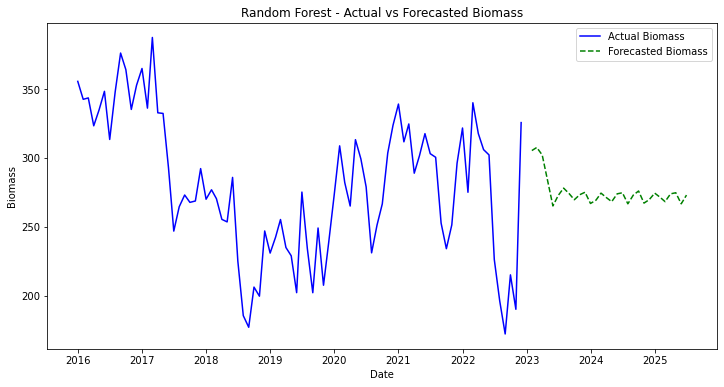

In [10]:
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Biomass'], label='Actual Biomass', color='blue')
plt.plot(future_series.index, future_series, label='Forecasted Biomass', color='green', linestyle='dashed')
plt.title('Random Forest - Actual vs Forecasted Biomass')
plt.xlabel('Date')
plt.ylabel('Biomass')
plt.legend()
plt.show()
